In [612]:
# predict the probability that an auto insurance policy holder files a claim

In [613]:
import os
import pandas as pd
import numpy as np
from numpy import mean
# from IPython.display import display # better for large datasets
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [614]:
os.chdir("C:\\Users\\A459648\\dsprojects\\porto-seguro-safe-driver-prediction")
# os.chdir("C:\\Users\\micha\\ds_data\\porto-seguro-safe-driver-prediction")

In [615]:
cdir = os.getcwd()

In [616]:
pd.set_option('display.max_columns', 100)  # or 1000
# pd.set_option('display.max_colwidth', None)  # or 199
pd.set_option('display.max_rows', 100)  # or 1000
# pd.set_option('display.max_colwidth', None)  # or 199

# pd.reset_option('all')

In [617]:
train_df = pd.read_csv(cdir + "\\" + "train.csv")

### First look at dataset

In [618]:
train_df.head(10)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0
5,19,0,5,1,4,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,1.8,2.332649,10,0,-1,0,0,14,1,1,0,1,104,2,0.445982,0.879049,0.406202,3.000000,0.7,0.8,0.4,3,1,8,2,11,3,8,4,2,0,9,0,1,0,1,1,1
6,20,0,2,1,3,1,0,0,1,0,0,0,0,0,0,0,8,1,0,0,0.6,0.1,0.617454,6,1,-1,0,1,11,1,1,0,1,99,2,0.316228,0.639683,0.368782,3.162278,0.2,0.6,0.5,2,2,8,1,8,3,10,3,0,0,10,0,1,0,0,1,0
7,22,0,5,1,4,0,0,1,0,0,0,0,0,0,0,0,13,1,0,0,0.7,0.4,0.607248,11,1,0,0,0,11,1,1,2,1,30,3,0.446990,0.900574,0.374833,3.316625,0.1,0.5,0.1,1,2,7,1,6,1,13,7,1,3,6,1,0,1,0,1,0
8,26,0,5,1,3,1,0,0,0,1,0,0,0,0,0,0,6,1,0,0,0.9,0.7,0.901388,10,1,-1,0,1,14,1,1,0,1,68,3,0.400000,0.780641,0.407431,2.828427,0.9,0.8,0.6,3,1,7,3,9,4,11,4,2,1,5,0,1,0,0,0,1
9,28,1,1,1,2,0,0,0,1,0,0,0,0,0,0,0,4,0,0,1,0.9,1.4,2.316652,11,0,0,1,0,14,1,1,2,1,104,2,0.447214,1.458184,0.390256,3.605551,0.7,0.8,0.8,2,2,8,2,9,1,11,3,5,0,6,0,1,0,0,1,0


In [619]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [620]:
# drop id
train_df = train_df.drop(columns=["id"])

In [621]:
# split train_df to X and y dataframes
X, y = train_df.iloc[:,1:], train_df.iloc[:,[0]]

In [622]:
# y

### Data imbalance check

In [623]:
# groupby target
y.groupby(by="target").size()

target
0    573518
1     21694
dtype: int64

21694 insured car owners filed a claim. \
573518 insured car owners did not file a claim.

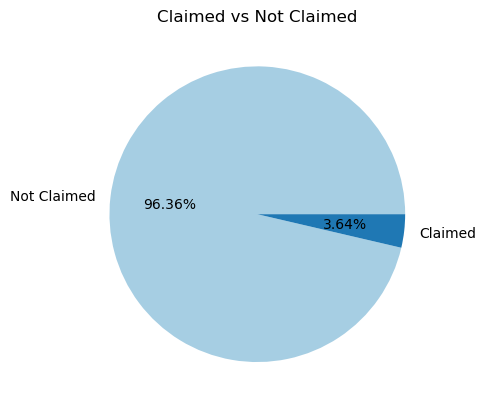

In [624]:
labels=["Not Claimed", "Claimed"]

claimed_or_not = y.value_counts().tolist()
values = [claimed_or_not[0],claimed_or_not[1]]
colors = sns.color_palette("Paired")

plt.pie(values, labels=labels, colors=colors, autopct='%.2f%%')
plt.title("Claimed vs Not Claimed")
plt.show()

##### Dataset is imbalanced.
Insured car owners who did not file a claim represent 96.36% of total insured car owners.\
Insured car owners who filed a claim represent 3.64% of total insured car owners.

In [625]:
# y = y.to_numpy()
# y = y.reshape(-1,)

In [626]:
# stratify=y to keep same proportions of classes for target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Model Training

#### Logistic Regression

In [627]:
# model = DecisionTreeClassifier()
model = LogisticRegression()

In [628]:
model.fit(X_train, y_train)

LogisticRegression()

In [629]:
# Check the class ordering
print("Classes:", model.classes_)

Classes: [0 1]


In [630]:
# y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:,1]

In [631]:
y_pred_prob

array([0.04154709, 0.03232524, 0.01713181, ..., 0.04207618, 0.02771307,
       0.02952807])

### Model evaluation

In [632]:
# # evaluate model, positive class
# # log loss
# logreg_log_loss = log_loss(y_test, y_pred_prob)
# print(f"Log Loss: {logreg_log_loss:.5f}")

# # ROC AUC
# logreg_roc_auc = roc_auc_score(y_test, y_pred_prob)
# print(f"ROC AUC: {logreg_roc_auc:.5f}")

# # Brier Score
# logreg_brier_score = brier_score_loss(y_test, y_pred_prob)
# print(f"Brier Score: {logreg_brier_score:.5f}")

In [633]:
models = pd.DataFrame({
    "Model":["Logistic Regression"], 
    "Log Loss Score":[logreg_log_loss],
    "ROC AUC Score":[logreg_roc_auc],
    "Brier Score":[logreg_brier_score]
})
models

,Model,Log Loss Score,ROC AUC Score,Brier Score
0,Logistic Regression,0.153793,0.609502,0.034924
